In [ ]:
!pip uninstall torchtext torch torchvision
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *
fastbook.setup_book()


In [45]:
import pandas as pd
from fastai.callback.fp16 import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!unzip '/content/gdrive/MyDrive/train.zip' -d '/content/gdrive/MyDrive/CropDisease'

In [ ]:
#!unzip '/content/gdrive/MyDrive/test.zip' -d '/content/gdrive/MyDrive/CropDisease'

In [46]:
train_path = Path('/content/gdrive/MyDrive/CropDisease/train')

In [47]:
fns = get_image_files(train_path)

In [48]:
def get_y(r): return L(parent_label(r))

In [49]:
# method to return dls
def get_dls(bs, size):    
  dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),                   
                     get_items=get_image_files,                   
                     get_y=get_y,                   
                     item_tfms=RandomResizedCrop(128),                   
                     batch_tfms=[*aug_transforms(size=size),                               
                                 Normalize()])    
  return dblock.dataloaders(train_path, bs=bs)


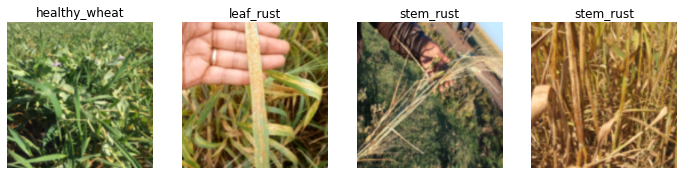

In [27]:
#dls.valid.show_batch(max_n=4, nrows=1)

In [50]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):    
  "Compute accuracy when `inp` and `targ` are the same size."    
  if sigmoid: inp = inp.sigmoid()    
  return ((inp>thresh)==targ.bool()).float().mean()

In [108]:
#create a dls for faster learning
dls = get_dls(128, 128)

In [109]:
# create the learner
learn = cnn_learner(dls, resnet101, metrics=partial(accuracy_multi, thresh=0.2), cbs=MixUp).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [110]:
# train pretrained models with fit_one_cycle
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.025196,0.753381,0.452381,01:41
1,0.953289,0.799854,0.431548,01:42
2,0.918260,0.725472,0.511905,01:40
3,0.887697,0.710188,0.523810,01:40


In [111]:
# new dls for better learning
learn.dls = get_dls(64, 224)

In [112]:
# train the learner
learn.fine_tune(5, base_lr=1e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.811156,0.557983,0.529762,01:42


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.813335,0.601254,0.553571,01:43
1,0.802236,0.621485,0.562500,01:45
2,0.784836,0.629872,0.571429,01:43
3,0.784265,0.630359,0.565476,01:43
4,0.775524,0.613694,0.574405,01:43


In [113]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

Minimum/10: 2.09e-04, steepest point: 9.12e-07


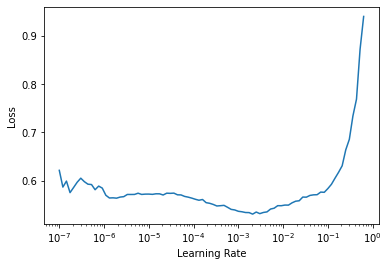

In [75]:
#lr_min,lr_steep = learn.lr_find()
#print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

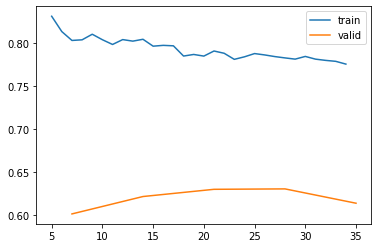

In [114]:
#plot the train and validation loss to see if the model is starting to overfit
learn.recorder.plot_loss()

In [115]:
#export the model if its good
learn.export('resnet101')

In [116]:
preds,targs = learn.get_preds()

In [21]:
preds.shape

torch.Size([112, 3])

In [117]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.7946)

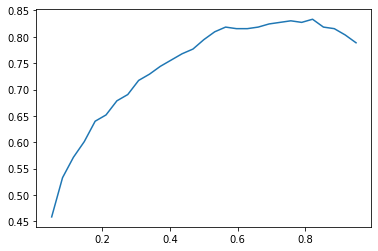

In [74]:
xs = torch.linspace(0.05,0.95,29) 
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs] 
plt.plot(xs,accs);

In [90]:
# method for prediction
def predict():
  predictions = []
  for f in Path('/content/gdrive/MyDrive/CropDisease/test').iterdir():
    path = Path(f)
    _,_,x = learn.predict(path)
    predictions.append(x)
  return predictions


In [118]:
preditions = predict()

In [ ]:
#file_name_list = []
#for f in Path('/content/gdrive/MyDrive/CropDisease/test').iterdir():
    #print(f)
    #path = Path(f)
#    file_name = os.path.basename(f)
    #file_name_without_extension = file_name.
#    file_name_list.append(os.path.splitext(file_name)[0] + ',')

In [ ]:
#file_name_list

In [119]:
#make a dataframe
sample_submission = pd.read_csv('/content/gdrive/MyDrive/CropDisease/sample_submission.csv')

data = {"leaf_rust, stem_rust, healthy_wheat": predictions}
index =  sample_submission['ID']

submission = pd.DataFrame(data, index)
#submission.index.name = 'ID,'

In [120]:
submission

,"leaf_rust, stem_rust, healthy_wheat"
ID,
643083,"[tensor(0.6658), tensor(0.6424), tensor(0.6149)]"
008FWT,"[tensor(0.4608), tensor(0.5089), tensor(0.2136)]"
00AQXY,"[tensor(0.7528), tensor(0.2194), tensor(0.1785)]"
01OJZX,"[tensor(0.6781), tensor(0.8745), tensor(0.0761)]"
07OXKK,"[tensor(0.4866), tensor(0.1342), tensor(0.6836)]"
...,...
ZKF0L9,"[tensor(0.7580), tensor(0.4474), tensor(0.6653)]"
ZMAB3R,"[tensor(0.6706), tensor(0.2289), tensor(0.4928)]"
ZOXDKA,"[tensor(0.8691), tensor(0.0627), tensor(0.0611)]"


In [121]:
#export to a csv fil
submission.to_csv('/content/gdrive/MyDrive/CropDisease_csv_progresive_resizing_resnet101.csv')